# Model Analysis 

This program takes in datasets and models, and computes the loss landscapes over varying amounts of data.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import time
import glob

# Importing our existing funcs
import os
import sys
from pathlib import Path

from minima_volume.dataset_funcs import ( load_models_and_data )

from minima_volume.landscape_videos import (
    compute_loss_landscape_3models,
    plot_2d_loss_landscape_3model,
    compute_loss_landscapes_varying_data,
    compute_loss_landscape_3models_varying_data,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

In [2]:
# User specifies the model module name
import MNIST_model_data as model_module

# Generate dataset
#x_base, y_base, x_test, y_test = model_module.get_dataset(
#    device = device
#)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=0)

# Grab loss and metrics
loss_fn_per_sample = model_module.get_loss_fn_per_sample()

## Loading Model and Datasets

In [3]:
# Get the relative path
target_dir = Path("models_and_data") #current directory

# Lists to store loaded models and additional data
loaded_models, loaded_additional_data, loaded_dataset = load_models_and_data(model_template=model_template, target_dir=target_dir, device="cpu")

# Print dataset information
print(f"Dataset type: {loaded_dataset['dataset_type']}")
print(f"Dataset quantities: {loaded_dataset['dataset_quantities']}")

# Print tensor shapes
print("\nTensor shapes:")
for key in ["x_base_train", "y_base_train", "x_additional", "y_additional", "x_test", "y_test"]:
    if loaded_dataset[key] is not None:
        print(f"  {key}: {loaded_dataset[key].shape}")
    else:
        print(f"  {key}: None")

Looking for models and dataset in: models_and_data
Found 6 model files:
  - model_additional_0.pt
  - model_additional_1940.pt
  - model_additional_19940.pt
  - model_additional_540.pt
  - model_additional_5940.pt
  - model_additional_59940.pt
✅ Model loaded into provided instance from models_and_data\model_additional_0.pt
Successfully loaded: model_additional_0.pt
✅ Model loaded into provided instance from models_and_data\model_additional_1940.pt
Successfully loaded: model_additional_1940.pt
✅ Model loaded into provided instance from models_and_data\model_additional_19940.pt
Successfully loaded: model_additional_19940.pt
✅ Model loaded into provided instance from models_and_data\model_additional_540.pt
Successfully loaded: model_additional_540.pt
✅ Model loaded into provided instance from models_and_data\model_additional_5940.pt
Successfully loaded: model_additional_5940.pt
✅ Model loaded into provided instance from models_and_data\model_additional_59940.pt
Successfully loaded: model_

## Plotting Parameters

Determines what models to use.

In [4]:
index1 = 3
index2 = 4
index3 = 5
index_list = [index1, index2, index3]

print(
    f"Loading models trained with: "
    f"{loaded_additional_data[index1]['additional_data']}, "
    f"{loaded_additional_data[index2]['additional_data']}, "
    f"{loaded_additional_data[index3]['additional_data']}"
)

model_0 = loaded_models[index1]
model_1 = loaded_models[index2]
model_2 = loaded_models[index3]

print("=== Selected Models ===")
dataset_type = loaded_dataset['dataset_type']
model_labels = [
    f"Model Trained with {loaded_additional_data[index1]['additional_data']} {dataset_type}",
    f"Model Trained with {loaded_additional_data[index2]['additional_data']} {dataset_type}",
    f"Model Trained with {loaded_additional_data[index3]['additional_data']} {dataset_type}"
]

# Prepare dataset with additional_data = 0 (base dataset only)
x_base_train = loaded_dataset['x_base_train']
y_base_train = loaded_dataset['y_base_train']
x_additional = loaded_dataset['x_additional']
y_additional = loaded_dataset['y_additional']

Loading models trained with: 540, 5940, 59940
=== Selected Models ===


## Loss Surface Generation

First, a sample visualization.

Grid size: 80x80, Range: [-0.5, 1.5]

=== Generating Loss Landscape ===
=== Computing loss landscapes for 3 data amounts ===
  ✓ Saved loss landscape for amount=540 as landscape_index_0_amount_540.npz
  ✓ Saved loss landscape for amount=5940 as landscape_index_1_amount_5940.npz
  ✓ Saved loss landscape for amount=59940 as landscape_index_2_amount_59940.npz
✓ Loss landscape generated and saved
=== Plotting Loss Landscapes ===


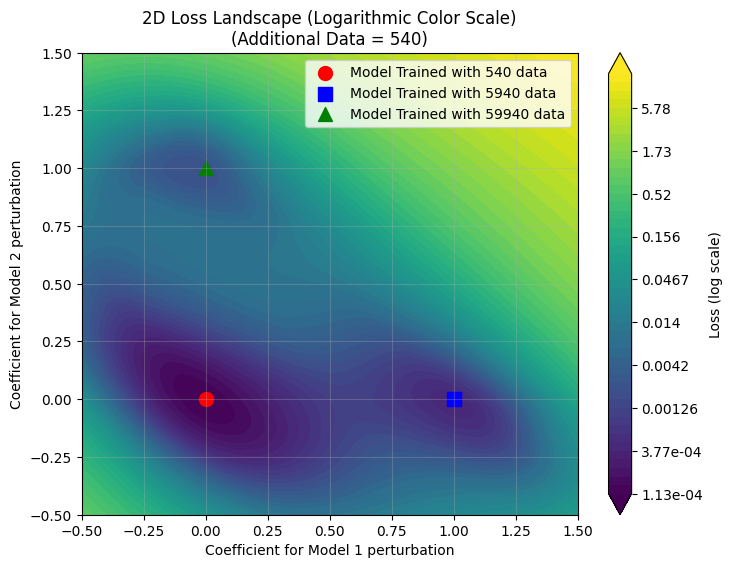

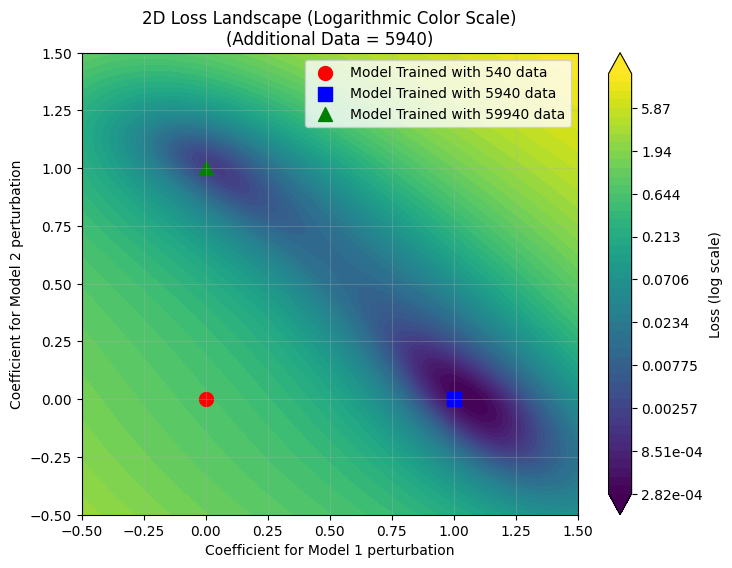

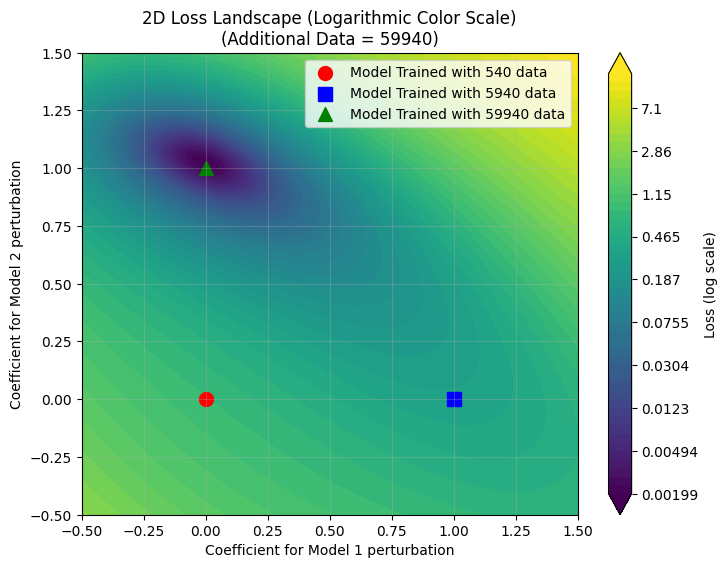

In [5]:
# Create quick_view directory
quick_view_dir = Path("quick_view")
quick_view_dir.mkdir(exist_ok=True)

# Create grid coefficients [-0.5, 1.5] with 80x80 points
N = 80
span_low = -0.5
span_high = 1.5

x = np.linspace(span_low, span_high, N)
y = np.linspace(span_low, span_high, N)
C1_grid, C2_grid = np.meshgrid(x, y)
grid_coefficients = (C1_grid, C2_grid)

print(f"Grid size: {N}x{N}, Range: [{span_low}, {span_high}]")

loss_grids = []

# Now begin assembling the datasets and computing different loss surfaces for this grid.
print("\n=== Generating Loss Landscape ===")
additional_data_amounts = [loaded_additional_data[index1]['additional_data'], 
                           loaded_additional_data[index2]['additional_data'], 
                           loaded_additional_data[index3]['additional_data']]
loss_grid_list, C1_grid, C2_grid = compute_loss_landscape_3models_varying_data( model_0=model_0,
                                                                                model_1=model_1,
                                                                                model_2=model_2,
                                                                                grid_coefficients=grid_coefficients,
                                                                                x_base = x_base_train,
                                                                                y_base = y_base_train,
                                                                                x_additional = x_additional,
                                                                                y_additional = y_additional,
                                                                                additional_data_amounts = additional_data_amounts,
                                                                                loss_fn_per_sample = loss_fn_per_sample,
                                                                                output_dir=quick_view_dir,
                                                                                base_filename="landscape" )

print("✓ Loss landscape generated and saved")

# Sample plot 
print("=== Plotting Loss Landscapes ===")

for i in range(3):
    # Plot 2D loss landscape
    plot_2d_loss_landscape_3model(
        C1_grid=C1_grid,
        C2_grid=C2_grid, 
        loss_grid=loss_grid_list[i],
        span_low=span_low,
        span_high=span_high,
        output_path=f"quick_view/loss_landscape_{loaded_additional_data[index_list[i]]['additional_data']}.png",
        additional_data = loaded_additional_data[index_list[i]]['additional_data'],
        model_labels = model_labels,
        show = True
    )

## Loss Landscape Computation Across Datasets

Loss landscape computation.

In [6]:
# Create storage directory
varying_dataset_dir = Path("varying_dataset")
varying_dataset_dir.mkdir(exist_ok=True)

# Define the additional data amounts to test
# This can be varied depending on the use case!!
# Example input
anchor_points = [600-60, 6000-60, 60000-60]   # specify 2, 3, or more points
steps_per_segment = 200               # how many intervals between each pair

additional_data_amounts = []

for i in range(len(anchor_points) - 1):
    start, end = anchor_points[i], anchor_points[i+1]
    # linspace includes both start and end, so skip first element except first segment
    segment = np.linspace(start, end, steps_per_segment + 1, dtype=int)
    if i > 0:
        segment = segment[1:]  # avoid repeating the start of each segment
    additional_data_amounts.extend(segment.tolist())

print(additional_data_amounts)

# Create grid
N = 80
span_low, span_high = -0.5, 1.5
x = np.linspace(span_low, span_high, N)
y = np.linspace(span_low, span_high, N)
C1_grid, C2_grid = np.meshgrid(x, y)
grid_coefficients = (C1_grid, C2_grid)

print(f"Grid size: {N}x{N}, Range: [{span_low}, {span_high}]")

[540, 567, 594, 621, 648, 675, 702, 729, 756, 783, 810, 837, 864, 891, 918, 945, 972, 999, 1026, 1053, 1080, 1107, 1134, 1161, 1188, 1215, 1242, 1269, 1296, 1323, 1350, 1377, 1404, 1431, 1458, 1485, 1512, 1539, 1566, 1593, 1620, 1647, 1674, 1701, 1728, 1755, 1782, 1809, 1836, 1863, 1890, 1917, 1944, 1971, 1998, 2025, 2052, 2079, 2106, 2133, 2160, 2187, 2214, 2241, 2268, 2295, 2322, 2349, 2376, 2403, 2430, 2457, 2484, 2511, 2538, 2565, 2592, 2619, 2646, 2673, 2700, 2727, 2754, 2781, 2808, 2835, 2862, 2889, 2916, 2943, 2970, 2997, 3024, 3051, 3078, 3105, 3132, 3159, 3186, 3213, 3240, 3267, 3294, 3321, 3348, 3375, 3402, 3429, 3456, 3483, 3510, 3537, 3564, 3591, 3618, 3645, 3672, 3699, 3726, 3753, 3780, 3807, 3834, 3861, 3888, 3915, 3942, 3969, 3996, 4023, 4050, 4077, 4104, 4131, 4158, 4185, 4212, 4239, 4266, 4293, 4320, 4347, 4374, 4401, 4428, 4455, 4482, 4509, 4536, 4563, 4590, 4617, 4644, 4671, 4698, 4725, 4752, 4779, 4806, 4833, 4860, 4887, 4914, 4941, 4968, 4995, 5022, 5049, 5076, 510

In [7]:
# Compute all loss landscapes
start_time = time.time()
loss_grids_list = compute_loss_landscape_3models_varying_data(
    model_0=model_0,
    model_1=model_1,
    model_2=model_2,
    grid_coefficients=grid_coefficients,
    x_base=x_base_train,
    y_base=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    additional_data_amounts=additional_data_amounts,
    loss_fn_per_sample=loss_fn_per_sample,
    output_dir=varying_dataset_dir,
    base_filename="landscape"
)
end_time = time.time()
elapsed = end_time - start_time

print(f"\n=== Total time for computing all loss landscapes: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes) ===")
print(f"✓ Completed all {len(loss_grids_list)} loss landscapes")

=== Computing loss landscapes for 401 data amounts ===
  ✓ Saved loss landscape for amount=540 as landscape_index_0_amount_540.npz
  ✓ Saved loss landscape for amount=567 as landscape_index_1_amount_567.npz
  ✓ Saved loss landscape for amount=594 as landscape_index_2_amount_594.npz
  ✓ Saved loss landscape for amount=621 as landscape_index_3_amount_621.npz
  ✓ Saved loss landscape for amount=648 as landscape_index_4_amount_648.npz
  ✓ Saved loss landscape for amount=675 as landscape_index_5_amount_675.npz
  ✓ Saved loss landscape for amount=702 as landscape_index_6_amount_702.npz
  ✓ Saved loss landscape for amount=729 as landscape_index_7_amount_729.npz
  ✓ Saved loss landscape for amount=756 as landscape_index_8_amount_756.npz
  ✓ Saved loss landscape for amount=783 as landscape_index_9_amount_783.npz
  ✓ Saved loss landscape for amount=810 as landscape_index_10_amount_810.npz
  ✓ Saved loss landscape for amount=837 as landscape_index_11_amount_837.npz
  ✓ Saved loss landscape for am